# Initial Exploration

(inspired by [this Kaggle notebook](https://www.kaggle.com/code/eishkaran/spotify-music-recommendation-system))


In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

2024-04-02 15:50:10.455090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
data = pd.read_csv("../data/data.csv")
genre_data = pd.read_csv('../data/data_by_genres.csv')
year_data = pd.read_csv('../data/data_by_year.csv')
artist_data = pd.read_csv('../data/data_by_artist.csv')

In [7]:
print(data.info())
print(genre_data.info())
print(year_data.info())
print(artist_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [8]:
year_data.pivot('year','duration_ms','energy').head()
plt.figure(figsize=(20,100))
pivot_table = year_data.pivot('year','duration_ms','energy')
plt.xlabel('year', size = 14)
plt.ylabel('duration_ms', size = 14)
plt.title('Energy over time', size = 14)
sns.heatmap(year_data, annot=True, linewidths=.4,linecolor='black', square=True, cmap='Greens_r',cbar=True);

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [10]:
df = pd.read_csv('../data/data.csv')
corr=df.corr()
corr

ValueError: could not convert string to float: "['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

Text(0.5, 0.98, '')

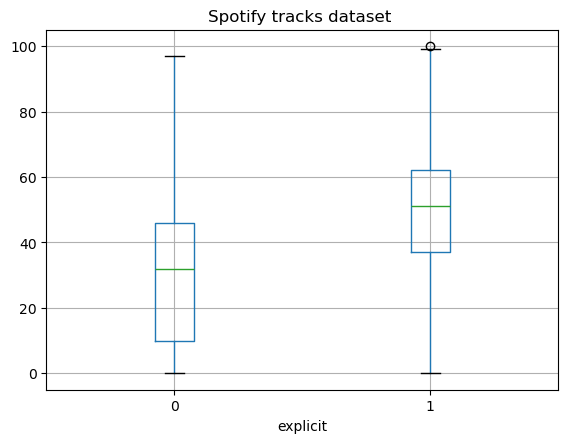

In [11]:
plot_df = pd.read_csv('../data/data.csv')
plot_df.head()
plot_df['explicit'].value_counts(dropna = False)
plot_df.boxplot(column='popularity', by ='explicit')
plt.title('Spotify tracks dataset ')
plt.suptitle('')

<Axes: xlabel='explicit', ylabel='popularity'>

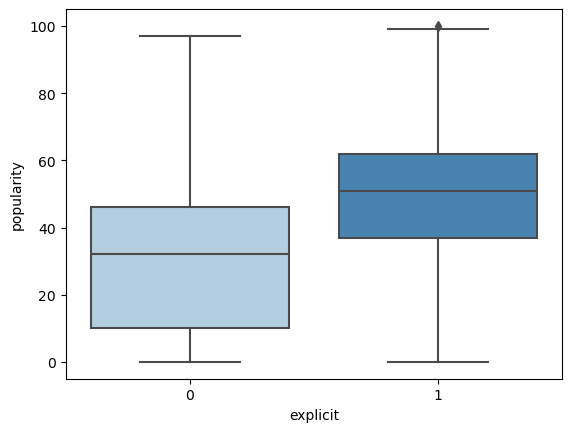

In [12]:
sns.boxplot(x='explicit', y='popularity', data=plot_df, palette='Blues' )

In [13]:
data= pd.read_csv('../data/data.csv')
x = data['duration_ms']
y = data['popularity']
plt.figure(figsize=(10,8))
sns.regplot(x, y,color="Skyblue", truncate=True)

TypeError: regplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

<Figure size 1000x800 with 0 Axes>

<Axes: xlabel='explicit', ylabel='popularity'>

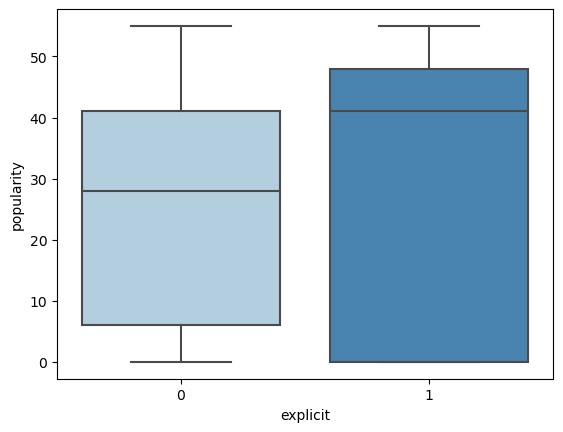

In [14]:
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 = 1.5 * IQR
    ls = df.index[(df[ft] < lower_bound) | (df[ft] > upper_bound)]
    return ls
index_list = []
for feature in ['popularity']:
    index_list.extend(outliers(plot_df, feature))
def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df
cleaned_df = remove(plot_df, index_list)
sns.boxplot(x='explicit', y='popularity', data = cleaned_df, palette='Blues')

In [15]:
data.head()
data.columns
data = data[['popularity','duration_ms','danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
data.head()
mean = np.mean(data)
std = np.std(data)
plt.plot(data)
plt.figure(figsize=(10,10))
plt.show()

KeyError: "['time_signature'] not in index"

In [16]:
data = data[['time_signature', 'duration_ms']]
data = pd.DataFrame(data)

plt.scatter(df['time_signature'], df['duration_ms'])
plt.xlabel('Time')
plt.ylabel('Duration')
plt.figure(figsize=(10,10))
plt.show()

KeyError: "['time_signature'] not in index"

In [17]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
